In [53]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.metrics import classification_report, confusion_matrix
import torch

### Training

In [54]:
# Load and combine data from files
data_0 = np.load('/kaggle/input/dl-project/DL-Project/data0.npy')
data_1 = np.load('/kaggle/input/dl-project/DL-Project/data1.npy')
data_2 = np.load('/kaggle/input/dl-project/DL-Project/data2.npy')

label_0 = np.load('/kaggle/input/dl-project/DL-Project/lab0.npy')
label_1 = np.load('/kaggle/input/dl-project/DL-Project/lab1.npy')
label_2 = np.load('/kaggle/input/dl-project/DL-Project/lab2.npy')

train_data = np.vstack((data_0, data_1, data_2))
train_lab = np.hstack((label_0, label_1, label_2))
print("Original dataset sizes:", train_data.shape, train_lab.shape)

# Extract image dimensions
img_rows = train_data.shape[1]
img_cols = train_data.shape[2]

# Reshape images to include channel dimension
train_data = train_data.reshape(-1, img_rows, img_cols, 1)
train_data = train_data.reshape(-1, img_rows, img_cols, 1)
print("Reformed dataset sizes:", train_data.shape, train_lab.shape)

Original dataset sizes: (30000, 40, 168) (30000,)
Reformed dataset sizes: (30000, 40, 168, 1) (30000,)


In [55]:
# Bilateral filter to reduce noise while preserving edges
def bilateral_filter(dataset, num_pix = 15):

  for i in range(dataset.shape[0]):
    image = dataset[i, :, :]
    mean_image = cv2.bilateralFilter(image, num_pix, 75, 75)
    dataset[i, :, :] = mean_image

  return dataset

# Evaluate model and display confusion matrix and classification report
def check_metrics(model, X_test, y_test):  

  y_pred = np.argmax(model.predict(X_test),axis = 1)
  y_true = np.argmax(y_test, axis=1)
  print('##############  Confusion Matrix  ##############')
  print()
  np.set_printoptions(threshold=np.inf)
  print(confusion_matrix(y_true, y_pred))
  np.set_printoptions(threshold=100)
  print()
  print('##############  Classification Report  ##############')
  print()
  target_names = [str(i) for i in range(10)]
  print(classification_report(y_true, y_pred, target_names=target_names))

# Resize image to fit specified dimensions using padding
def resize_to_fit(image, width, height):
    
    deltaw = width - image.shape[1]
    deltah = height - image.shape[0]
    if (deltaw < 0 or deltah < 0):
      if (deltaw < 0):
        image = image[:, :28]
        deltaw = width - image.shape[1]
      if (deltah < 0):
        image = image[:28, :]
        deltah = height - image.shape[0]
    if (deltaw % 2 == 0):
      padW1 = int(deltaw/2)
      padW2 = padW1
    else:
      padW1 = int(deltaw/2)
      padW2 = padW1 + 1
    if (deltah % 2 == 0):
      padH1 = int(deltah/2)
      padH2 = padH1
    else:
      padH1 = int(deltah/2)
      padH2 = padH1 + 1
    image = cv2.copyMakeBorder(image, padH1, padH2, padW1, padW2, cv2.BORDER_CONSTANT, value=0)
    return image

In [56]:
# Load MNIST data for training
with np.load('/kaggle/input/mnist-data/mnist.npz') as data:
    trainX = data['x_train']
    trainY = data['y_train']
    testX = data['x_test']
    testY = data['y_test']

# Preprocess MNIST data    
trainX = trainX.astype('float32')
testX = testX.astype('float32')
# Apply bilateral filter to reduce noise
trainX = bilateral_filter(trainX, 5)
testX = bilateral_filter(testX, 5)
# Reshape to include channel dimension
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# Convert labels to one-hot encoding
trainY = to_categorical(trainY)
testY = to_categorical(testY)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)
# Normalize pixel values
trainX = trainX.astype('float32')
trainX /= 255.0
testX = testX.astype('float32')
testX /= 255.0

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


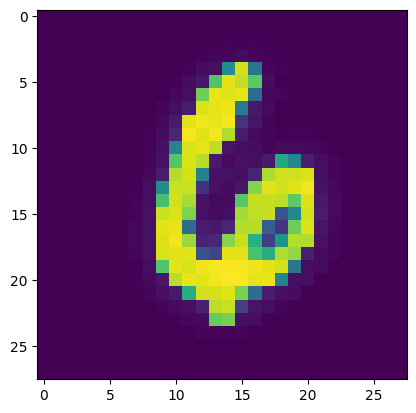

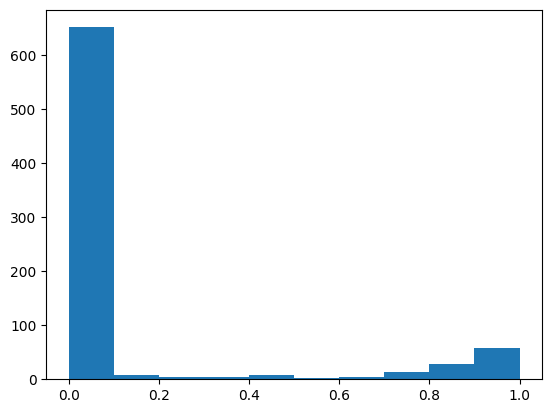

In [57]:
index = 39

plt.imshow(trainX[index].reshape(28,28))
plt.show()
plt.hist(trainX[index].reshape(28, 28).ravel(),10,[0,1])
plt.show()

In [58]:
# Check for GPU availability and assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
# Define CNN model
with tf.device('/gpu:0'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 9, 9, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 100)                 │         102,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,254 (622.09 KB)

 Trainable params: 159,254 (622.09 KB)

 Non-trainable params: 0 (0.00 B)

None


In [60]:
# Train model
batch_size = 200
num_epoch = 10
model_log = model.fit(trainX, trainY, batch_size=batch_size, epochs=num_epoch, verbose=1, validation_data=(testX, testY))

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 118ms/step - accuracy: 0.8573 - loss: 0.4817 - val_accuracy: 0.9810 - val_loss: 0.0605
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - accuracy: 0.9831 - loss: 0.0565 - val_accuracy: 0.9850 - val_loss: 0.0454
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.9869 - loss: 0.0425 - val_accuracy: 0.9904 - val_loss: 0.0304
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - accuracy: 0.9916 - loss: 0.0258 - val_accuracy: 0.9894 - val_loss: 0.0322
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 37s 122ms/step - accuracy: 0.9931 - loss: 0.0212 - val_accuracy: 0.9898 - val_loss: 0.0344
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 121ms/step - accuracy: 0.9949 - loss: 0.0160 - val_accuracy: 0.9912 - val_loss: 0.0290
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.9962 - loss: 0.0121 - val_accuracy: 0.9911 - val_loss: 0.0284
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 121ms/step - accuracy: 0.9956 - loss: 0

In [61]:
# Save model and weights 
file_name = "MNIST_Model"
model_json = model.to_json()
with open(file_name + ".json", "w") as json_file:
    json_file.write(model_json)

model.save_weights(file_name +".weights.h5")
print("Model Saved")

Model Saved


### Inference

In [62]:
# Load saved model and weights
json_file = open('/kaggle/working/MNIST_Model.json')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

model.load_weights('/kaggle/working/MNIST_Model.weights.h5')
print("Loaded model from disk")

# Evaluate loaded model on test data
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

Loaded model from disk


### Plot of Accuracy and Loss vs Epochs

<Figure size 640x480 with 0 Axes>

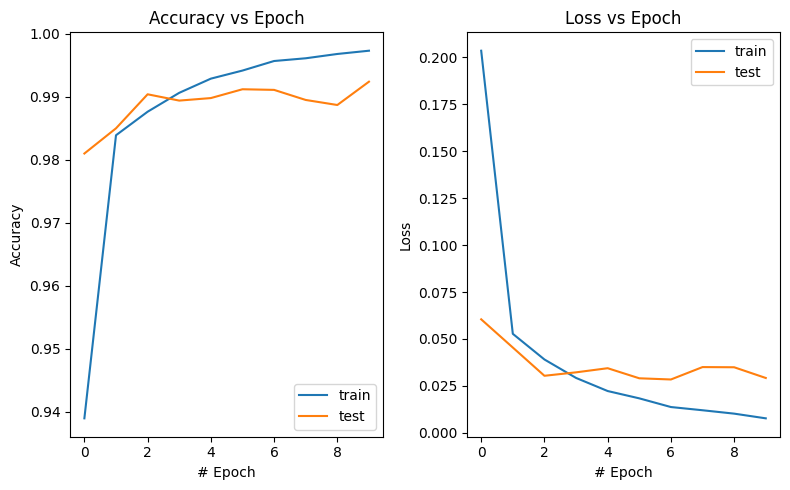

In [64]:
fig = plt.figure()
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('# Epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

### Metrics

In [65]:
check_metrics(model, testX, testY)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
##############  Confusion Matrix  ##############

[[ 977    0    0    0    1    0    1    1    0    0]
 [   0 1131    0    0    0    1    1    1    1    0]
 [   1    1 1026    0    1    0    0    2    1    0]
 [   0    0    0 1006    0    4    0    0    0    0]
 [   0    0    0    0  981    0    0    0    0    1]
 [   1    0    0    3    0  885    1    0    2    0]
 [   2    1    0    0    2    1  949    0    3    0]
 [   0    3    6    0    0    0    0 1014    0    5]
 [   1    0    1    1    1    1    0    0  967    2]
 [   1    0    0    0   13    5    1    1    0  988]]

##############  Classification Report  ##############

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       0.98      1.00      0.99       9

### Digit Extraction and Contour Analysis

In [66]:
bad_image_count = 0
bad_image_dict = dict()
correct = 0
semicorrect = 0
incorrect = 0

# Configure output display and range
show = 0
start = 0
end = 1000

# Process each image in dataset
for (i,image) in enumerate(train_data[start:end]):

    # Display progress every 100 images
    if(i>0 and i%100 == 0):
      print(i, correct, semicorrect, incorrect, int(correct/(correct+incorrect+semicorrect)*10000)/100,
            int(semicorrect/(correct+incorrect+semicorrect)*10000)/100,
            int(incorrect/(correct+incorrect+semicorrect)*10000)/100, "Done")
    
    # Pad image to ensure no digits touch the border
    padded_image = cv2.copyMakeBorder(image, 8, 8, 8, 8, cv2.BORDER_REPLICATE)

    # if(show == 1):
    #   plt.imshow(padded_image)
    #   plt.show()
      
    # Find contours in the image
    contours = cv2.findContours(padded_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[1] if imutils.is_cv3() else contours[0]
    letter_image_regions = [] # Store detected digit regions

    # Handle cases where contour is too wide to be a single letter => split connected digits
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        
        if (w > 40): # Likely 3 connected digits
            onethird_width = int(w / 3)
            letter_image_regions.append((x, y, onethird_width, h))
            letter_image_regions.append((x + onethird_width, y, onethird_width, h))
            letter_image_regions.append((x + 2*onethird_width, y, onethird_width, h))
        
        elif (w > 20): # Likely 2 connected digits
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        
        elif (w< 3 or h<9):  # Error in contouring, ignore!
            continue
        
        else:
            letter_image_regions.append((x, y, w, h))
        
    # Log error if less or more than 4 detected digits take note of the error
    if len(letter_image_regions) != 4:
        bad_image_count+=1
        if (str(len(letter_image_regions)) not in bad_image_dict):
            bad_image_dict[str(len(letter_image_regions))] = [i] 
        else:
            bad_image_dict[str(len(letter_image_regions))].append(i)

    # Sort the detected digit regions by x-coordinate (L->R)
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    
    sum = 0

    # Process each detected digit
    for letter_bounding_box in letter_image_regions:
        x, y, w, h = letter_bounding_box

        # Extract digit from padded image and resize to fit model
        letter_image = padded_image[y-2:y + h+2, x-2:x + w+2]
        modified_image = resize_to_fit(letter_image, 28, 28)

        # Normalize pixel values and apply bilateral filtering
        modified_image = modified_image.astype('float32')
        modified_image = cv2.bilateralFilter(modified_image, 7, 15, 15)
        modified_image /= 255.0
        
        # Display processed digit
        # if(show == 1):
        #   plt.imshow(modified_image)
        #   plt.show()
        #   plt.hist(modified_image.ravel(),10,[0,1])
        #   plt.show()

        # Predict digit using model
        model_prediction = np.argmax(model.predict(modified_image.reshape(1, 28, 28, 1)),axis = 1)[0]
        # if(show == 1):
        #   print(model_prediction)
        sum += model_prediction

    # if(show == 1):
    #   print(train_lab[start+i], sum)
    
    # Compare predicted sum with label
    if ((train_lab[i+start] - sum) == 0):
      correct +=1
    elif ((train_lab[i+start] - sum) % 5 == 0):
      semicorrect +=1
    else:
      incorrect +=1

# Prin overall classification statistics
print("Correctly classified:", correct)
print("Semi-correctly classified:", semicorrect)
print("Incorrectly classified:", incorrect)
print("Percentage Accuracy:", int(correct/(correct+incorrect+semicorrect)*10000)/100)
print("Percentage Semi-Accuracy:", int(semicorrect/(correct+incorrect+semicorrect)*10000)/100)
print("Percentage Inaccuracy:", int(incorrect/(correct+incorrect+semicorrect)*10000)/100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [68]:
# Print error statistics
print(bad_image_count)
for key in bad_image_dict:
    print("Number of images with " + str(key) + " detected digits: " + str(len(bad_image_dict[key])))    
print("Printing wrongly localised image indices")
print(bad_image_dict)

2
Number of images with 3 detected digits: 1
Number of images with 5 detected digits: 1
Printing wrongly localised image indices
{'3': [25], '5': [245]}
